In [1]:
%matplotlib inline
from pylab import *
from numpy import *
import neuron
import pyNN
from pyNN import neuron
from pyNN.standardmodels import electrodes, build_translations, StandardCurrentSource
from pyNN.parameters import ParameterSpace, Sequence
from pyNN.neuron import simulator
from pyNN.utility import get_simulator, normalized_filename
from pyNN.utility.plotting import Figure, Panel
from neuron import h
from quantities import mV,Hz, s ,ms
import elephant as ep
import elephant.kernels as kernels
from elephant.spike_train_generation import threshold_detection
from elephant.spike_train_dissimilarity import victor_purpura_dist
from elephant.spike_train_dissimilarity import van_rossum_dist
import seaborn as sns
import neo
import quantities as pq
import numpy as np
from scipy.optimize import minimize
from sklearn import preprocessing
from operator import add

In [2]:
#amps = linspace(-10, 10, 10)
thresh = linspace(-70, -50, 10)
cell = neuron.Population(10, neuron.IF_curr_exp(v_thresh = -50, tau_refrac = 5.0, tau_m = 10.0))
for cell_id in arange(0,10,1):
    print(cell_id)
    cell[cell_id:(cell_id+1)].set(v_thresh= thresh[cell_id])
    pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = -10, offset = 0.1, frequency = 10, phase = 180.0)
    cell[cell_id].inject(pulse)
#for cell_id in arange(0,500):
#pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = amps[cell_id], offset = 0.1, frequency = 10, phase = 180.0)
    cell[cell_id].inject(pulse)
cell.record('v')
neuron.run(100.0)

0
1
2
3
4
5
6
7
8
9


100.00000000001417

In [3]:
cell.get('v_thresh')

array([-70.        , -67.77777778, -65.55555556, -63.33333333,
       -61.11111111, -58.88888889, -56.66666667, -54.44444444,
       -52.22222222, -50.        ])

In [4]:
vm = cell.get_data().segments[0].filter(name = "v")[0]
print(len(vm))

4001


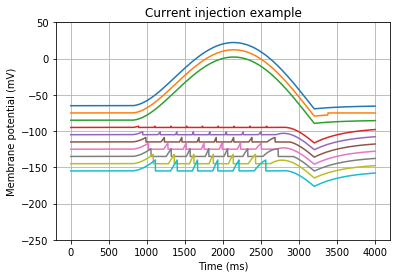

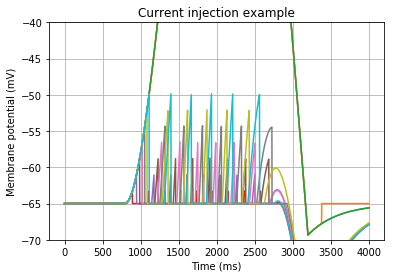

In [5]:
plt.figure()
for cell_id in arange(0,10):
    plt.plot(vm[:,cell_id]-10*mV*cell_id)
plt.grid()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.ylim(-250, 50)
plt.title("Current injection example");
plt.figure()
for cell_id in arange(0,10):
    plt.plot(vm[:, cell_id])
plt.grid()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.ylim(-70, -40)
plt.title("Current injection example");

In [6]:
Tvm = vm.T
target = Tvm[3,:]
åtte = Tvm[8,:]
ni = Tvm[9,:]
savetxt('vm.txt', Tvm)
shape(Tvm)
#self reminder that matrices are row,column

(10, 4001)

[[1.         0.99987671 1.         0.43361879 0.43666331 0.44134517
  0.44029383 0.45737515 0.44832351 0.4552719 ]
 [0.99987671 1.         0.99987671 0.42887901 0.43178368 0.43657047
  0.4355229  0.45282291 0.44366151 0.45109279]
 [1.         0.99987671 1.         0.43361879 0.43666331 0.44134517
  0.44029383 0.45737515 0.44832351 0.4552719 ]
 [0.43361879 0.42887901 0.43361879 1.         0.99107411 0.97559411
  0.95774061 0.90453443 0.88719133 0.86327098]
 [0.43666331 0.43178368 0.43666331 0.99107411 1.         0.96989312
  0.95881834 0.89720743 0.89106289 0.85861434]
 [0.44134517 0.43657047 0.44134517 0.97559411 0.96989312 1.
  0.94138436 0.90819823 0.87939417 0.84209616]
 [0.44029383 0.4355229  0.44029383 0.95774061 0.95881834 0.94138436
  1.         0.87711047 0.86316553 0.84915417]
 [0.45737515 0.45282291 0.45737515 0.90453443 0.89720743 0.90819823
  0.87711047 1.         0.83718923 0.78394195]
 [0.44832351 0.44366151 0.44832351 0.88719133 0.89106289 0.87939417
  0.86316553 0.83718

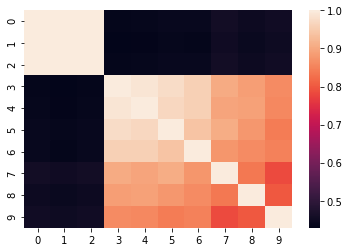

In [7]:
Tvmc = corrcoef(Tvm)
targetTvmc = Tvmc[3,:]
#print(vmc)
sns.heatmap(Tvmc)
print(Tvmc)
print(shape(Tvmc))

In [8]:
trains = {}
for cell_id in arange(3,10):
    trains[cell_id] = threshold_detection(vm[:,cell_id], threshold=-56.00*mV, sign='above')

In [9]:
for train in trains.values():
    if (len(train) > 0):
        print(train)

[25.775 32.725 39.    45.15  51.35  57.85  66.3  ] ms
[25.775 33.4   39.975 46.375 52.85  59.875] ms
[25.775 34.05  40.95  47.575 54.4   62.1  ] ms


[[0.    0.    0.    0.    7.    6.    6.   ]
 [0.    0.    0.    0.    7.    6.    6.   ]
 [0.    0.    0.    0.    7.    6.    6.   ]
 [0.    0.    0.    0.    7.    6.    6.   ]
 [7.    7.    7.    7.    0.    1.512 2.036]
 [6.    6.    6.    6.    1.512 0.    0.528]
 [6.    6.    6.    6.    2.036 0.528 0.   ]]
[[0.         0.         0.         0.         0.63636364 0.54545455
  0.54545455]
 [0.         0.         0.         0.         0.63636364 0.54545455
  0.54545455]
 [0.         0.         0.         0.         0.63636364 0.54545455
  0.54545455]
 [0.         0.         0.         0.         0.63636364 0.54545455
  0.54545455]
 [0.49199315 0.49199315 0.49199315 0.49199315 0.         0.10627052
  0.14309972]
 [0.49560562 0.49560562 0.49560562 0.49560562 0.12489262 0.
  0.04361329]
 [0.49249187 0.49249187 0.49249187 0.49249187 0.16711891 0.04333928
  0.        ]]


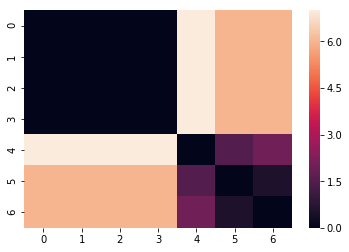

In [10]:
distance_matrix1 = victor_purpura_dist(trains.values(), q=array(80.0) * Hz)
print(distance_matrix1)
d1_norm = preprocessing.normalize(distance_matrix1)
sns.heatmap(distance_matrix1)
print(d1_norm)

In [11]:
trains[8].dimensionality.simplified

Dimensionality({second: 1})

In [12]:
isinstance(trains[8], (pq.quantity.Quantity, neo.core.SpikeTrain))

True

In [13]:
type(trains[8])

neo.core.spiketrain.SpikeTrain

[[0.         0.         0.         0.         0.62047259 0.55953869
  0.54948177]
 [0.         0.         0.         0.         0.62047259 0.55953869
  0.54948177]
 [0.         0.         0.         0.         0.62047259 0.55953869
  0.54948177]
 [0.         0.         0.         0.         0.62047259 0.55953869
  0.54948177]
 [0.48679436 0.48679436 0.48679436 0.48679436 0.         0.15433962
  0.16823878]
 [0.4878543  0.4878543  0.4878543  0.4878543  0.1715199  0.
  0.13628511]
 [0.48603153 0.48603153 0.48603153 0.48603153 0.18967685 0.13826095
  0.        ]]


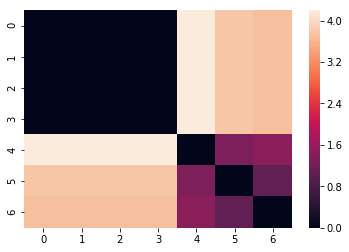

In [14]:
distance_matrix2 = van_rossum_dist(trains.values(), tau=array(10.0) * pq.ms, sort = True)
sns.heatmap(distance_matrix2)
d2_norm = preprocessing.normalize(distance_matrix2)
#print(distance_matrix2)
print(d2_norm)

In [15]:
new = np.subtract(target, ni)
abnew = [abs(x) for x in new]
nmax = np.amax(abnew)
print(nmax)
nmin = np.amin(abnew)
print(nmin)
nsum = np.sum(abnew)
print(nsum)
print(len(new))
diff = []
i = 0;
ccf = corrcoef(Tvm)
print(ccf[[3,4],:])

15.157240594917539
0.0
5443.019918250337
4001
[[0.43361879 0.42887901 0.43361879 1.         0.99107411 0.97559411
  0.95774061 0.90453443 0.88719133 0.86327098]
 [0.43666331 0.43178368 0.43666331 0.99107411 1.         0.96989312
  0.95881834 0.89720743 0.89106289 0.85861434]]


In [1]:
%matplotlib inline
from pylab import *
from numpy import *
import neuron
import pyNN
from pyNN import neuron
from pyNN.standardmodels import electrodes, build_translations, StandardCurrentSource
from pyNN.parameters import ParameterSpace, Sequence
from pyNN.neuron import simulator
from pyNN.utility import get_simulator, normalized_filename
from pyNN.utility.plotting import Figure, Panel
from neuron import h
from quantities import mV,Hz, s ,ms
import elephant as ep
import elephant.kernels as kernels
from elephant.spike_train_generation import threshold_detection
from elephant.spike_train_dissimilarity import victor_purpura_dist
from elephant.spike_train_dissimilarity import van_rossum_dist
import seaborn as sns
import neo
import quantities as pq
import numpy as np
from scipy.optimize import minimize
from sklearn import preprocessing
from operator import add

In [2]:
def optimize(a , b, c, d, e, f, g, h, i, j, k, l, m):
#a is start of linspace for voltage threshhold of the cell
#b is the end of the linspace
#c is the number of steps
#d is the start time for the source current
#e is the end time for the current
#f is the amplitude of the current
#g is the the offset
#h is the frequency 
#i is the phase
#d-i would come as the followingL
#start = 20.0, stop = 80.0, amplitude = -10, offset = 0.1, frequency = 10, phase = 180.0
#j is the total run time for the model
#k is the target column of the voltage outputs given by the model
#l is the penalty value (hertz) for victor_purpura_dist function (distance function)
#m is the penalty value (time) for van_rossum_dist function (distance function)
    thresh = linspace(a, b, c)
    cell = neuron.Population(c, neuron.IF_curr_exp(v_thresh = -50, tau_refrac = 5.0, tau_m = 10.0))
    for cell_id in arange(0,c,1):
        print(cell_id)
        cell[cell_id:(cell_id+1)].set(v_thresh= thresh[cell_id])
        pulse = neuron.ACSource(start = d, stop = e, amplitude = f, offset = g, frequency = h, phase = i)
        cell[cell_id].inject(pulse)
    cell.record('v')
    neuron.run(j)
    cell.get('v_thresh')
    vm = cell.get_data().segments[0].filter(name = "v")[0]
    Tvm = vm.T
    #transpose matrix, mentally just works better in my head 
    Tvmc = corrcoef(Tvm)
    targetTvmc = Tvmc[k,:]
    ttarget = lambda targetTvmci:(1-targetTvmci)/(1-targetTvmc.min())
    ttarget = np.vectorize(ttarget)
    true = ttarget(targetTvmc)
    #currently working to create a loop that would allow for the creation of a column vector for each column to be analyzed and compated
    savetxt('truetarget.txt', true)
    trains = {}
    for cell_id in arange(0,c):
        trains[cell_id] = threshold_detection(vm[:,cell_id], threshold=-56.00*mV, sign='above')
    distance_matrix1 = victor_purpura_dist(trains.values(), q=array(l) * Hz)
    #print(distance_matrix1)
    d1_norm = preprocessing.normalize(distance_matrix1)
    targetd1 = d1_norm[k,:]
    distance_matrix2 = van_rossum_dist(trains.values(), tau=array(m) * pq.ms, sort = True)
    #print(distance_matrix2)
    d2_norm = preprocessing.normalize(distance_matrix2)
    targetd2 = d2_norm[k,:]
    print("Target VM")
    print(true)
    print("Target Distance 1 Array")
    print(targetd1)
    print("Target Distance 2 Array")
    print(targetd2)
    ntot = true + targetd1 + targetd2
    print("Total Scale")
    print(ntot)
    return

In [ ]:
optimize(-70,-50,100,20,90,-5,.05,15,180,100.0,3,50.0,10.0)

In [20]:
targetTvmc

array([0.43361879, 0.42887901, 0.43361879, 1.        , 0.99107411,
       0.97559411, 0.95774061, 0.90453443, 0.88719133, 0.86327098])

In [24]:
ttarget = lambda targetTvmci:(1-targetTvmci)/(1-targetTvmc.min())
ttarget = np.vectorize(ttarget)
ttarget(targetTvmc)

array([9.91700924e-01, 1.00000000e+00, 9.91700924e-01, 3.88787331e-16,
       1.56287113e-02, 4.27333102e-02, 7.39937578e-02, 1.67154727e-01,
       1.97521485e-01, 2.39404651e-01])